In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy.sparse.linalg import cg
import matplotlib.pyplot as plt
import matplotlib.tri
import okada_wrapper
import tectosaur as tct

In [3]:
TCTN = 21
CURVE = 1.0

corners = [[-1, 0, -1], [1, 0, -1], [1, 0, 1], [-1, 0, 1]]
src_mesh = tct.make_rect(TCTN, TCTN, corners)
src_mesh[0][:,1] = CURVE * np.abs(src_mesh[0][:,0])
#src_mesh[0][:,1] = CURVE * (src_mesh[0][:,0] ** 2 + src_mesh[0][:,2] ** 2)
def gauss_slip_fnc(x, z):
    r2 = x ** 2 + z ** 2
    R = 1.0
    out = (np.cos(np.sqrt(r2) * np.pi / R) + 1) / 2.0
    out[np.sqrt(r2) > R] = 0.0
    return out
dof_pts = src_mesh[0][src_mesh[1]]
x = dof_pts[:,:,0]
z = dof_pts[:,:,2]
slip = np.zeros((src_mesh[1].shape[0], 3, 3)).astype(np.float32)
slip[:,:,0] = gauss_slip_fnc(x, z)

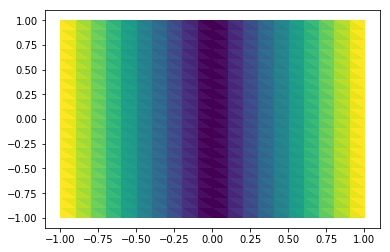

In [4]:
plt.tripcolor(src_mesh[0][:,0], src_mesh[0][:,2], src_mesh[1], src_mesh[0][:,1])
plt.show()

In [5]:
H = tct.RegularizedSparseIntegralOp(
    6, 6, 6, 2, 5, 2.5,
    'elasticRH3', 'elasticRH3', [1.0, 0.25], src_mesh[0], src_mesh[1], np.float32,
    farfield_op_type = tct.TriToTriDirectFarfieldOp
)

[4349:DEBUG:tectosaur.util.gpu]
    start compiling assemble.cl
[4518:INFO:tectosaur.util.opencl]
    initializing opencl context with devices = ['Intel(R) Core(TM) i7-7600U CPU @ 2.80GHz']
[4569:DEBUG:tectosaur.util.gpu]
     compile took 0.22045158399851061
[4576:DEBUG:tectosaur.util.gpu]
    returning cached gpu module assemble.cl
[4582:DEBUG:tectosaur.nearfield.nearfield_op]
         setup pairs integrator took 0.3670699060021434
[4975:DEBUG:tectosaur.nearfield.nearfield_op]
         Coincident took 0.39222990900452714
[4993:DEBUG:tectosaur.nearfield.nearfield_op]
         Coincident correction took 0.01713634899351746
[5020:DEBUG:tectosaur.nearfield.nearfield_op]
         Find nearfield/adjacency took 0.0260051640070742
[6118:DEBUG:tectosaur.nearfield.nearfield_op]
         Edge adjacent took 1.0975733759987634
[6135:DEBUG:tectosaur.nearfield.nearfield_op]
         Edge adjacent correction took 0.0157595929922536
[7312:DEBUG:tectosaur.nearfield.nearfield_op]
         Vert adjacent

In [6]:
traction_mass_op = tct.MassOp(4, src_mesh[0], src_mesh[1])

In [7]:
dof_pts = src_mesh[0][src_mesh[1]]
from tectosaur.util.geometry import unscaled_normals
ns = unscaled_normals(dof_pts)
ns /= np.linalg.norm(ns, axis = 1)[:, np.newaxis]
ns = np.repeat(ns, 3, axis = 0)

In [8]:
edge_dofs = tct.free_edge_dofs(src_mesh[1], tct.find_free_edges(src_mesh[1]))

In [9]:
obs_pts = dof_pts.reshape((-1,3))[edge_dofs]
obs_ns = ns[edge_dofs]
interior_op = tct.InteriorOp(obs_pts.copy(), obs_ns.copy(), src_mesh, 'elasticH3', 10, 6, 6, [1.0, 0.25], np.float32)

[8016:DEBUG:tectosaur.util.gpu]
    start compiling matrix_free.cl
[8069:DEBUG:tectosaur.util.gpu]
     compile took 0.052368210002896376
[8151:DEBUG:tectosaur.util.gpu]
    start compiling assemble.cl
[8210:DEBUG:tectosaur.util.gpu]
     compile took 0.05976606199692469
[8218:DEBUG:tectosaur.util.gpu]
    returning cached gpu module assemble.cl
[8245:DEBUG:tectosaur.util.gpu]
    returning cached gpu module assemble.cl
[8257:DEBUG:tectosaur.util.gpu]
    returning cached gpu module assemble.cl


In [10]:
trac_edges = -interior_op.dot(slip.flatten())

In [11]:
vec_edge_dofs = np.tile(3 * np.array(edge_dofs)[:,np.newaxis], (1,3))
vec_edge_dofs[:,1] += 1
vec_edge_dofs[:,2] += 2
vec_edge_dofs = vec_edge_dofs.flatten()

In [19]:
cs1 = tct.continuity_constraints(src_mesh[0], src_mesh[1], src_mesh[1].shape[0])
# cs12 = cs1
cs1 = tct.traction_admissibility_constraints(src_mesh[0], src_mesh[1])
cs = cs1 + tct.simple_constraints(vec_edge_dofs, trac_edges)

In [20]:
cm, c_rhs, c_rhs_mat = tct.build_constraint_matrix(cs, src_mesh[1].shape[0] * 9)

In [21]:
# for i in range(10):
#     C1 = cs12[i]
#     C2 = cs1[i]
#     print((C1.terms[0].dof, C1.terms[0].val), (C1.terms[1].dof, C1n.terms[1].val))
#     print((C2.terms[0].dof, C2.terms[0].val), (C2.terms[1].dof, C2.terms[1].val))

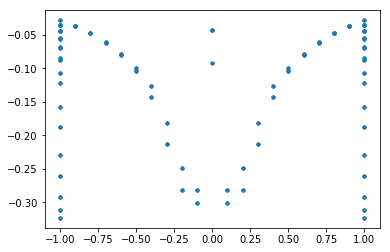

In [22]:
plt.plot(obs_pts[:,0], trac_edges.reshape((-1,3))[:,0], '.')
plt.show()

In [23]:
constrained_traction_mass_op = cm.T.dot(traction_mass_op.mat.dot(cm))

In [24]:
rhs = -cm.T.dot(H.dot(slip.flatten())) - cm.T.dot(traction_mass_op.mat.dot(c_rhs))
#rhs = -cm.T.dot(traction_mass_op.mat.dot(c_rhs2))
soln = cg(constrained_traction_mass_op, rhs)
out = cm.dot(soln[0]) + c_rhs

[19237:DEBUG:tectosaur.ops.sparse_integral_op]
    start farfield_dot
[19366:DEBUG:tectosaur.ops.sparse_integral_op]
     farfield_dot took 0.12931907500023954
[19369:DEBUG:tectosaur.ops.sparse_integral_op]
    start nearfield_dot
[19397:DEBUG:tectosaur.ops.sparse_integral_op]
     nearfield_dot took 0.028252734991838224


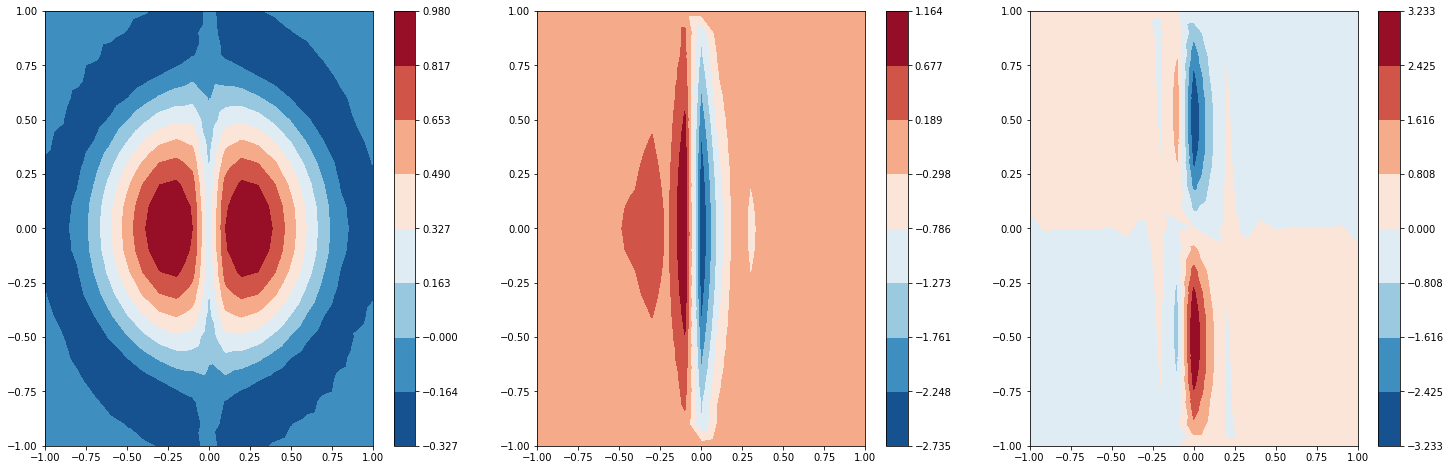

In [25]:
def plot_fnc(triang, f):
    levels = np.linspace(np.min(f) - 1e-12, np.max(f) + 1e-12, 9)
    #levels = np.linspace(-0.2, 0.2, 31)
    cntf = plt.tricontourf(triang, f, levels = levels, cmap = 'RdBu_r')
    #plt.tricontour(triang, f, levels = levels, linestyles = 'solid', colors = 'k', linewidths = 0.5)
    plt.colorbar(cntf)

triang = matplotlib.tri.Triangulation(src_mesh[0][:,0], src_mesh[0][:,2], src_mesh[1])
plt.figure(figsize = (25,8))
for d in range(3):
    f = out.reshape((-1,3,3))[:,:,d]
    f_pts = np.zeros(src_mesh[0].shape[0])
    f_pts[src_mesh[1]] = f
    plt.subplot(1, 3, d + 1)
    plot_fnc(triang, f_pts)
plt.show()